In [49]:
import torch
import torch.nn as nn
import pennylane as qml
import torch.nn.functional as F

In [50]:
pennylane_version = qml.__version__
print(f"Versión de PennyLane: {pennylane_version}")

Versión de PennyLane: 0.35.1


In [135]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits,
                n_qlayers=2,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit.torch"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size #features
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        #self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        #self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        #self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        #self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]
        wires_list=list(range(self.n_qubits))
        self.dev_forget = qml.device(self.backend, wires=wires_list,torch_device='cuda')
        self.dev_input = qml.device(self.backend, wires=wires_list,torch_device='cuda')
        self.dev_update = qml.device(self.backend, wires=wires_list,torch_device='cuda')
        self.dev_output = qml.device(self.backend, wires=wires_list,torch_device='cuda')

        def _circuit_forget(inputs, weights):
            #trainable layer W0
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            wires_list=list(range(self.n_qubits))
            kernel_size=self.n_qubits//2
            for b in range(self.n_qubits//2): #the blocks in which the input repeats "vertically"
                    w=0
                    for inp in range(kernel_size):
                        wi=int(wires_list[w+inp])
                        qml.RY(inputs[inp],wires=wi)
                    w=w+kernel_size
            #Trainable layer W1
            pesos=weights[1,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_list)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_list]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch",diff_method='backprop')

        def _circuit_input(inputs, weights):
            #trainable layer W0
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            wires_list=list(range(self.n_qubits))
            kernel_size=self.n_qubits//2
            for b in range(self.n_qubits//2): #the blocks in which the input repeats "vertically"
                    w=0
                    for inp in range(kernel_size):
                        wi=int(wires_list[w+inp])
                        qml.RY(inputs[inp],wires=wi)
                    w=w+kernel_size
            #Trainable layer W1
            pesos=weights[1,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_list)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_list]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch",diff_method='backprop')

        def _circuit_update(inputs, weights):
            #trainable layer W0
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            wires_list=list(range(self.n_qubits))
            kernel_size=self.n_qubits//2
            for b in range(self.n_qubits//2): #the blocks in which the input repeats "vertically"
                    w=0
                    for inp in range(kernel_size):
                        wi=int(wires_list[w+inp])
                        qml.RY(inputs[inp],wires=wi)
                    w=w+kernel_size
            #Trainable layer W1
            pesos=weights[1,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_list)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_list]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch",diff_method='backprop')

        def _circuit_output(inputs, weights):
            #trainable layer W0
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            wires_list=list(range(self.n_qubits))
            kernel_size=self.n_qubits//2
            for b in range(self.n_qubits//2): #the blocks in which the input repeats "vertically"
                    w=0
                    for inp in range(kernel_size):
                        wi=int(wires_list[w+inp])
                        qml.RY(inputs[inp],wires=wi)
                    w=w+kernel_size
            #Trainable layer W1
            pesos=weights[1,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch",diff_method='backprop')

        weight_shapesf = {"weights": (n_qlayers, n_qubits)}
        weight_shapesi = {"weights": (n_qlayers, n_qubits)}
        weight_shapesu = {"weights": (n_qlayers, n_qubits)}
        weight_shapeso = {"weights": (n_qlayers, n_qubits)}
        device = torch.device('cuda')
        
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")
        kernel_size=self.n_qubits//2
        self.clayer_in = torch.nn.Linear(self.concat_size, kernel_size)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapesf),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapesi),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapesu),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapeso)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        device = torch.device('cuda')
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size).to(device)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size).to(device)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :] #x has shape (batch,seq_len,features)
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t) #it has size (batch_size, hidden)
            hidden_seq.append(h_t.unsqueeze(0)) #we will end with a number of sequences of the size of the window of time 
        hidden_seq = torch.cat(hidden_seq, dim=0) #(window, batch_size,hidden)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous() #(batch_size,window,hidden)
        return hidden_seq, (h_t, c_t)

HYBRID CIRCUIT
=================

In [136]:
class HLstm(nn.Module):
    def __init__(self, input_size, hidden_dim, n_qubits, target_size=5,  backend='default.qubit.torch'):
        super(HLstm,self).__init__()
        self.input_size=input_size
        self.hidden_dim=hidden_dim
        self.n_qubits=n_qubits
        self.lstm = QLSTM(self.input_size, self.hidden_dim, self.n_qubits, backend=backend)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
    def forward(self, sequence):
        
        lstm_out, _ = self.lstm(sequence)
        #print('el shape de lstm_out',lstm_out.shape)
        #target = self.hidden2tag(lstm_out.view(len(sequence), -1))
        target = self.hidden2tag(lstm_out[:, -1, :]) #we take the last h_t. It has shape (batch_size,hidden). We map it to (batch_size,features)
        #print('el shape del target',target.shape)
        #tag_scores = F.log_softmax(tag_logits, dim=1)
        return target

Classic architectureee (only to verify which dimensions we should have)
==

In [137]:
# Definir la arquitectura de la red LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype=torch.float).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,dtype=torch.float).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        #print('el shape de classic lstm_out',out.shape)
        out = self.fc(out[:, -1, :])  # Tomar la última salida de la secuencia
        #print('el shape de classic lstm_out luego dee self.fc(out[:, -1, :]',out.shape)
        return out

In [138]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pytorch_model_summary import summary
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import r2_score

#from qlstm_pennylane import QLSTM



In [139]:
# Verificar si hay una GPU disponible y establecer el dispositivo
device = torch.device('cuda')
print('el device es',device)
df = pd.read_csv('BTC_1m_210601_230126.csv')
data_btc = df.iloc[:, 1:6].values

el device es cuda


In [140]:
data_btc_30min = np.reshape(data_btc, (29024, 30, 5))
data_btc_open = data_btc_30min[:,0,0]
data_btc_close = data_btc_30min[:,29,3]
data_btc_high = np.amax(data_btc_30min[:,:,1], axis=1)
data_btc_low = np.amin(data_btc_30min[:,:,2], axis=1)
data_btc_volume = np.sum(data_btc_30min[:,:,4], axis=1)
data_btc_30min = np.concatenate((data_btc_open[:,None], data_btc_high[:,None], data_btc_low[:,None], data_btc_close[:,None], data_btc_volume[:,None]), axis=1)

In [141]:
data_btc_30min=data_btc_30min[0:5000,:]

In [142]:
scaler = MinMaxScaler()
scaled_data_btc = scaler.fit_transform(data_btc_30min)

In [143]:
def create_sequences(data, sequence_length):
    sequences = []
    columna_close=3
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length:i+sequence_length+1]
        
        sequences.append((seq, label)) #el label si tiene tamaño (1,features)
    return sequences

In [144]:
sequence_length = 4  # Longitud de la secuencia de entrada
# Create sequences and corresponding labels for training set
sequences = create_sequences(scaled_data_btc, sequence_length)

In [145]:
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# Crear DataLoader para cargar los datos
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [146]:
def train_model(model,train_loader, num_epochs, learning_rate):
    # Función de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = []

    # Entrenamiento del modelo
    for epoch in range(num_epochs):
        for seq, label in train_loader:
            seq = seq.float()
            label = label.squeeze(1)
            # Mover las secuencias y etiquetas a la GPU
            seq, label = seq.to(device), label.to(device)
            #print('el shape de seq es',seq.shape)
            #print('el shape de labeel es',label.shape)
            outputs = model(seq)
            #print('outputs',outputs.shape)
            optimizer.zero_grad()
            loss = criterion(outputs, label.float())
            loss.backward()
            optimizer.step()
            
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.11f}')
        loss_list.append(loss.item())

    return loss_list

In [147]:
torch.__version__

'2.0.1+cu118'

In [148]:
# Hiperparámetros
sequence_length = 4  # Longitud de la secuencia de entrada
input_size = 5       # Features
hidden_size = 64     # Tamaño de la capa oculta LSTM
qubits=8             #
num_layers = 1      # Número de capas LSTM
output_size = 5      # Features de salida (solo es un punto)
learning_rate = 0.02
num_epochs = 50
#seed 
torch.manual_seed(0)

model = HLstm(input_size,hidden_size,qubits,output_size)
model.to(device)
loss_list=train_model(model,train_loader, num_epochs, learning_rate)



weight_shapes = (n_qlayers, n_qubits) = (2, 8)


RuntimeError: shape '[64, -1]' is invalid for input of size 4

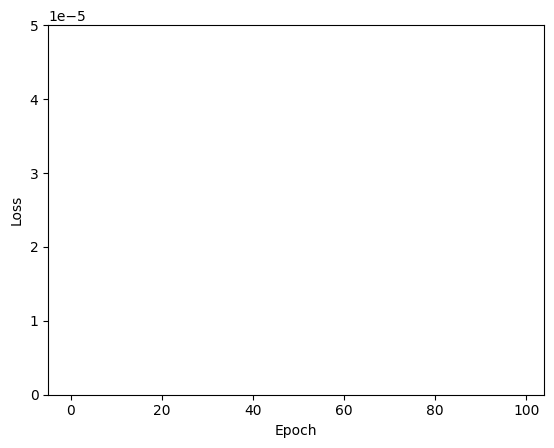

In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axis(ymin=0,ymax=0.00005)
plt.show()

In [ ]:
def save_model(model,name):
    #guardar el modelo
    torch.save(model.state_dict(), 'weights/'+ name + '.pth')
    

In [ ]:
print(loss_list)

[0.5053025484085083, 0.38982778787612915, 0.3162999451160431, 0.271583616733551, 0.24564440548419952, 0.23062807321548462, 0.22120743989944458, 0.21415220201015472, 0.20755131542682648, 0.20022131502628326, 0.19131183624267578, 0.18004955351352692, 0.16567297279834747, 0.14756153523921967, 0.12556423246860504, 0.10065759718418121, 0.07566909492015839, 0.05446254462003708, 0.039112456142902374, 0.029009202495217323, 0.022575147449970245, 0.018455587327480316, 0.015718583017587662, 0.013791462406516075, 0.012352761812508106, 0.011226699687540531, 0.010313475504517555, 0.009552663192152977, 0.008905526250600815, 0.008345936425030231, 0.007855570875108242, 0.007421146146953106, 0.00703273992985487, 0.006682802923023701, 0.006365408189594746, 0.006075853016227484, 0.005810348782688379, 0.005565794184803963, 0.005339618306607008, 0.005129676312208176, 0.0049341595731675625, 0.004751518834382296, 0.004580448381602764, 0.004419796634465456, 0.00426857965067029, 0.004125931300222874, 0.00399109

In [ ]:
#save_model(model,'cuda_lstm')

In [ ]:
def predict(model, test_data):
    # Poner el modelo en modo de evaluación
    model.eval()
    # Determinar el dispositivo (CPU o GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Mover el modelo al dispositivo
    model.to(device)

    with torch.no_grad():
        test_predictions = []
        for data_point in test_data:
            test_seq = torch.FloatTensor(data_point[0]).unsqueeze(dim=0).to(device)
            prediction = model(test_seq)
            test_predictions.append(prediction)
    
    # Concatenar las predicciones y retornar
    return torch.cat(test_predictions, dim=0)


In [ ]:
test_predictions= predict(model,test_data)

In [ ]:
test_predictions = test_predictions.cpu()
test_predictions_np = test_predictions.numpy()

In [ ]:
def plot_predictions(test_data,test_predictions):
    #reverse scaling
    test_predictions=scaler.inverse_transform(test_predictions)
    #print(test_data.shape)
    test_data=scaler.inverse_transform(np.array(test_data))
    
    plt.figure(figsize=(10, 6)) 

    #plot datos btc and test_predictions
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_data[len(train_data)+sequence_length:len(scaled_data_btc),3],label='Original Values')
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_predictions[:,3],label='Predicted Values')
    #if you can see with more detail the plot, uncomment the next line
    #plt.axis(xmin=25000, xmax=25030, ymin=0.085, ymax=0.1)

    plt.ylabel('BTC/USD')
    plt.xlabel('Time (30 min)')
    plt.title('BTC/USD Testing Phase')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
    plt.tight_layout()
    #plt.savefig('plots_lstm/prediction_plot.png',dpi=300)
    plt.show()

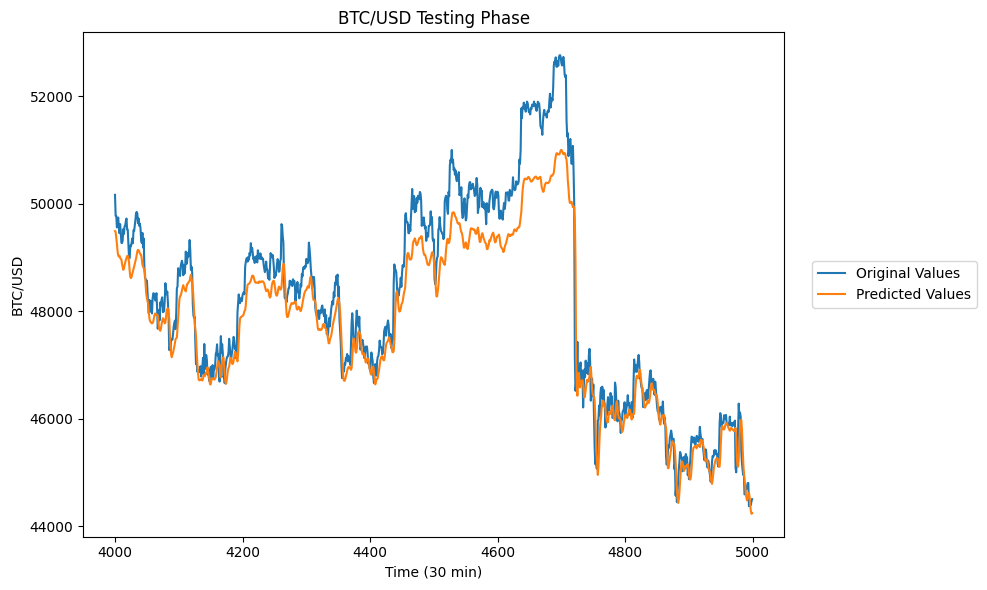

In [ ]:
plot_predictions(scaled_data_btc,test_predictions)

In [ ]:
def rmse(predictions, targets):
    # Assuming predictions and targets are NumPy arrays
    # Calculate the RMSE
    
    RMS = np.sqrt(np.mean(np.power((targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3] - predictions[:,3]), 2)))
    print('RMS', RMS)
    return RMS

def rsquare(predictions, targets):
    r2 = r2_score(targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3], predictions[:,3])
    print('r2',r2)
    return r2

In [ ]:
RMS=rmse(test_predictions_np, scaled_data_btc)
r2=rsquare(test_predictions_np, scaled_data_btc)

RMS 0.026621631869477424
r2 0.8929595552053209
